In [1]:
import glob
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
compute_capabilities = {'p100': 60, '1080': 61, 'v100': 70, '2080ti': 75}
algorithms = {0: 'Gemm', 1: 'Implicit-Gemm', 2: 'Implicit-Precompile-Gemm'}
raw_features = ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw']
features = raw_features + ['params', 'flops'] + ['algo', 'cc']
targets = ['latency', 'power', 'energy']

def feature_engineering(df: pd.DataFrame):
    df['params'] = df['out_channels'] * (np.square(df['kernel_size']) * df['in_channels'] / df['groups'] + 1)
    df['flops'] = np.square(df['hw'] // df['stride'])

In [3]:
configs = pd.read_csv('./search_space/regnet_convs_unique.csv')
test_size = int(len(configs) * 0.2)
test_cfg_strs = []
for i, row in configs.iterrows():
    test_cfg_strs.append('_'.join([str(int(row[k])) for k in raw_features]))
    if i >= test_size:
        break
print(f'Train: {len(configs) - test_size} / Test: {test_size}')

Train: 3859 / Test: 964


In [4]:
def read_logs(mode: str = 'energy'):
    dfs = []
    for path in glob.glob(f'logs/*/{mode}/*.csv'):
        _, device, _, file_name = path.split('/')
        algo = int(file_name.split('-')[0])
        df = pd.read_csv(path)
        feature_engineering(df)
        df['cc'] = compute_capabilities[device]
        df['algo'] = algo
        df['test'] = [
            '_'.join([str(int(row[k])) for k in raw_features]) in test_cfg_strs
            for i, row in df.iterrows()
        ]
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

energy_df = read_logs('energy')

# latency_df = read_logs('latency')
# print(f'Energy: {len(energy_df)} / Latency: {len(latency_df)} ')

energy_df

,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,algo,profile_energy,num_warmups,num_iters,latency,energy,power,params,flops,cc,test
0,1680,1680,3,1,10,7,2,1,1,200,12357,0.000769,0.047850,62.248666,2541840.0,49,70,True
1,3000,3000,3,2,25,14,2,1,1,200,8269,0.001168,0.114717,98.196631,3243000.0,49,70,True
2,208,52,1,1,1,14,2,1,1,200,49722,0.000127,0.006383,50.396915,10868.0,196,70,True
3,792,792,3,2,11,7,2,1,1,200,22645,0.000215,0.011520,53.641023,514008.0,9,70,True
4,448,448,3,2,4,56,2,1,1,200,5220,0.001958,0.115479,58.969292,452032.0,784,70,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57871,4,16,1,1,1,112,0,2,1,200,33055,0.000213,0.016950,79.488633,80.0,12544,75,False
57872,420,1680,1,1,1,14,0,2,1,200,19834,0.000413,0.044370,107.455305,707280.0,196,75,False
57873,2088,2088,3,1,9,14,0,2,1,200,9923,0.000982,0.182331,185.664953,4361832.0,196,75,False
57874,88,22,1,1,1,28,0,2,1,200,49680,0.000140,0.011216,80.166620,1958.0,784,75,False


In [5]:
def calc_grid_size(df: pd.DataFrame, channel_thres: int, hw_thres: int, precomp: bool):
    channel_scale = np.ceil(df['out_channels'] / channel_thres)
    hw = df['hw'] - (df['kernel_size'] - 1) * precomp
    hw_scale = np.ceil(np.square(hw / df['stride']) / hw_thres)
    return (channel_scale * hw_scale).astype(np.int32)

def add_grid_size(df):
    df['grid_size_0'] = calc_grid_size(df, 32, 32, df['algo'] == 2)
    df['grid_size_1'] = calc_grid_size(df, 128, 64, df['algo'] == 2)

grid_size_features = ['grid_size_0', 'grid_size_1']
add_grid_size(energy_df)
# add_grid_size(latency_df)
energy_df

,in_channels,out_channels,kernel_size,stride,groups,hw,gpu_id,algo,profile_energy,num_warmups,num_iters,latency,energy,power,params,flops,cc,test,grid_size_0,grid_size_1
0,1680,1680,3,1,10,7,2,1,1,200,12357,0.000769,0.047850,62.248666,2541840.0,49,70,True,106,14
1,3000,3000,3,2,25,14,2,1,1,200,8269,0.001168,0.114717,98.196631,3243000.0,49,70,True,188,24
2,208,52,1,1,1,14,2,1,1,200,49722,0.000127,0.006383,50.396915,10868.0,196,70,True,14,4
3,792,792,3,2,11,7,2,1,1,200,22645,0.000215,0.011520,53.641023,514008.0,9,70,True,25,7
4,448,448,3,2,4,56,2,1,1,200,5220,0.001958,0.115479,58.969292,452032.0,784,70,True,350,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57871,4,16,1,1,1,112,0,2,1,200,33055,0.000213,0.016950,79.488633,80.0,12544,75,False,392,196
57872,420,1680,1,1,1,14,0,2,1,200,19834,0.000413,0.044370,107.455305,707280.0,196,75,False,371,56
57873,2088,2088,3,1,9,14,0,2,1,200,9923,0.000982,0.182331,185.664953,4361832.0,196,75,False,330,51
57874,88,22,1,1,1,28,0,2,1,200,49680,0.000140,0.011216,80.166620,1958.0,784,75,False,25,13


In [6]:
def calc_rmse(y: np.ndarray, pred: np.ndarray):
    return np.sqrt(np.mean(np.square(y - pred)))

def calc_err(y: np.ndarray, pred: np.ndarray):
    return np.abs(y - pred) / y

def calc_acc(err: np.ndarray, thres: np.ndarray):
    return sum(err <= thres) / len(err) * 100

class Predictor(object):

    def __init__(self, data: pd.DataFrame, features: list[str], target: str = 'energy'):
        print(f'Features: {features}, Target: {target}')
        self._model = xgb.XGBRegressor(
            eta=0.2,
            gamma=0.001,
            n_estimators=200,
            max_depth=10,
            min_child_weight=0,
            seed=2022,
        )
        self._features = features
        self._target = target
        self._log2 = (target != 'power')
        X = data[features]
        y = data[target]
        if self._log2:
            y = np.log2(y)
        self._model.fit(X, y)

    def predict(self, data: pd.DataFrame):
        pred = self._model.predict(data[self._features])
        if self._log2:
            pred = np.exp2(pred)
        return pred

    def evaluate(self, data: pd.DataFrame, desc: str = ''):
        pred = self.predict(data)
        err = calc_err(data[self._target], pred)
        results = [calc_acc(err, thres) for thres in [0.05, 0.10, 0.15]]
        results.append(calc_rmse(data[self._target], pred))
        print(f'[{desc}({self._target}): {len(data)}]')
        print('5%% : %2.2f%% | 10%% : %2.2f%% | 15%% : %2.2f%% | RMSE : %1.5f' % tuple(results))
        return results

    def save(self, path: str):
        self._model.save_model(path)

In [7]:
# latency_predictor = Predictor(latency_df, features + grid_size_features, target='latency')

# latency_predictor.evaluate(latency_df, desc='Train')
# latency_predictor.evaluate(energy_df, desc='Test')

# latency_hat = latency_predictor.predict(energy_df)
# energy_df['latency_hat'] = latency_hat

# energy_df

In [8]:
for target in targets:
    Predictor(energy_df, features, target).save(f'./predictor/models/{target}.model')

Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'params', 'flops', 'algo', 'cc'], Target: latency
Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'params', 'flops', 'algo', 'cc'], Target: power
Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'params', 'flops', 'algo', 'cc'], Target: energy


In [9]:
accs = []
all_features = features  # + grid_size_features + ['latency_hat']
for target in targets:
    train_df = energy_df[energy_df['test'] == False]
    test_df = energy_df[energy_df['test'] == True]
    predictor = Predictor(train_df, all_features, target)
    predictor.evaluate(train_df, desc=f'Train')
    for device, cc in compute_capabilities.items():
        for algo_id, algo_name in algorithms.items():
            filter = (test_df['cc'] == cc) & (test_df['algo'] == algo_id)
            accs.append(predictor.evaluate(test_df[filter], desc=f'Test({device})({algo_name})'))

accs = np.array(accs).reshape((
    len(targets),
    len(compute_capabilities),
    len(algorithms),
    -1,
))

Features: ['in_channels', 'out_channels', 'kernel_size', 'stride', 'groups', 'hw', 'params', 'flops', 'algo', 'cc'], Target: latency
[Train(latency): 46296]
5% : 80.27% | 10% : 96.06% | 15% : 98.97% | RMSE : 0.00008
[Test(p100)(Gemm)(latency): 965]
5% : 40.41% | 10% : 70.78% | 15% : 87.25% | RMSE : 0.00028
[Test(p100)(Implicit-Gemm)(latency): 965]
5% : 47.67% | 10% : 77.72% | 15% : 90.05% | RMSE : 0.00029
[Test(p100)(Implicit-Precompile-Gemm)(latency): 965]
5% : 50.98% | 10% : 79.27% | 15% : 89.84% | RMSE : 0.00026
[Test(1080)(Gemm)(latency): 965]
5% : 39.07% | 10% : 68.19% | 15% : 87.46% | RMSE : 0.00034
[Test(1080)(Implicit-Gemm)(latency): 965]
5% : 37.72% | 10% : 67.25% | 15% : 83.73% | RMSE : 0.00027
[Test(1080)(Implicit-Precompile-Gemm)(latency): 965]
5% : 51.71% | 10% : 80.83% | 15% : 92.85% | RMSE : 0.00026
[Test(v100)(Gemm)(latency): 965]
5% : 45.91% | 10% : 76.99% | 15% : 91.30% | RMSE : 0.00026
[Test(v100)(Implicit-Gemm)(latency): 965]
5% : 47.05% | 10% : 76.99% | 15% : 90.88

In [10]:
for target, results in zip(targets, accs.mean(axis=(1, 2))):
    print(f'[Test(average)({target})]')
    print('5%% : %2.2f%% | 10%% : %2.2f%% | 15%% : %2.2f%% | RMSE : %1.5f' % tuple(results))

[Test(average)(latency)]
5% : 50.28% | 10% : 77.79% | 15% : 90.43% | RMSE : 0.00026
[Test(average)(power)]
5% : 78.79% | 10% : 93.84% | 15% : 97.55% | RMSE : 4.40979
[Test(average)(energy)]
5% : 51.12% | 10% : 78.13% | 15% : 90.03% | RMSE : 0.02956


In [11]:
def summary(metric: str):
    ind = np.arange(len(algorithms))
    fig = plt.figure(figsize=(8, 12))
    fig.subplots_adjust(hspace=0.3)
    for i, target in enumerate(targets):
        ax = plt.subplot(311 + i)
        for j, device in enumerate(compute_capabilities.keys()):
            width = 1 / (len(compute_capabilities) + 1)
            ind_shift = ind + (j - len(compute_capabilities) / 2 + 0.5) * width
            extra_params = {'color': f'C{j}', 'edgecolor': 'black', 'width': width}
            if metric == 'Accuracy':
                ax.bar(ind_shift, accs[i, j, :, 2], hatch='', **extra_params, label=device.capitalize())
                ax.bar(ind_shift, accs[i, j, :, 1], hatch='/', **extra_params)
                ax.bar(ind_shift, accs[i, j, :, 0], hatch='//', **extra_params)
            else:
                ax.bar(ind_shift, accs[i, j, :, 3], **extra_params, label=device.capitalize())
        ax.set_xticks(ind, list(algorithms.values()))
        if metric == 'Accuracy':
            ax.set_yticks(np.arange(11) * 10)
        ax.grid()
        ax.set_axisbelow(True)
        ax.set_xlabel('Algorithm')
        ax.set_ylabel(metric)
        ax.legend()
        ax.set_title(f'{target.capitalize()} Predictor {metric}')

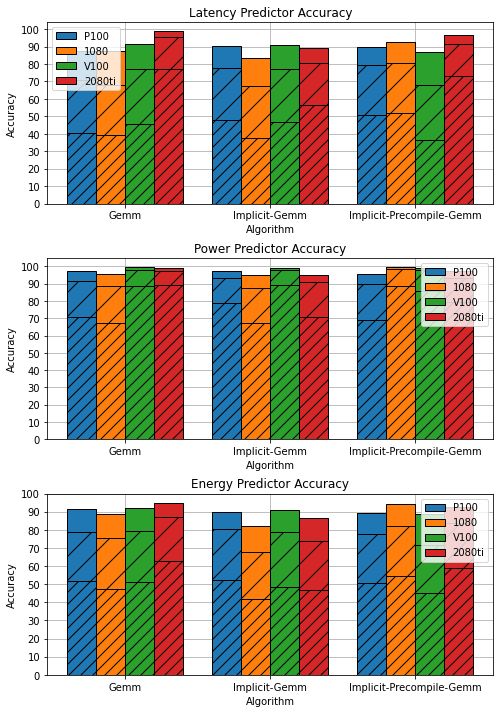

In [12]:
summary('Accuracy')

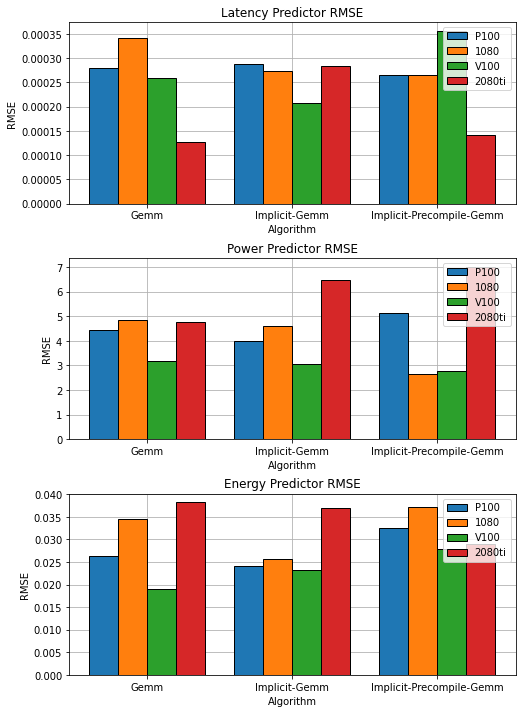

In [13]:
summary('RMSE')